In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from architectures.fc_models import binary_out

2024-03-31 16:51:45.523322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-31 16:51:45.723681: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 16:51:45.723724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 16:51:45.753371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 16:51:45.812481: I tensorflow/core/platform/cpu_feature_guar

In [2]:
PATCH_SIZE = 32
BINARY_SIZE = 64
STEPS = 4

In [3]:
def get_data():
    from keras.datasets import cifar10

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    x_train = (x_train - 0.5) * 2
    x_test = (x_test - 0.5) * 2

    return x_train, x_test

In [4]:
def l2_loss(y_true, y_pred):
    # normalize the loss by the number of pixels
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

In [5]:
class Decoder(tf.keras.Model):
    def __init__(self, binary_size, patch_size):
        super(Decoder, self).__init__()
        self.binary_size = binary_size
        self.patch_size = patch_size
    
        self.custom_layers = [
            tf.keras.layers.Dense(128, activation='tanh'),
            tf.keras.layers.Dense(128, activation='tanh'),
            tf.keras.layers.Dense(128, activation='tanh'),
            tf.keras.layers.Dense(patch_size*patch_size*3, activation='tanh')
        ]

    def call(self, inputs):
        x = inputs
        for layer in self.custom_layers:
            x = layer(x)
        x = tf.reshape(x, [-1, self.patch_size, self.patch_size, 3])
        return x

In [6]:
def resBlock(inputs, binary_size, patch_size):
    binary = None
    
    inputs = tf.reshape(inputs, [-1, PATCH_SIZE * PATCH_SIZE * 3])
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(binary_size, activation=binary_out, use_bias=False, trainable=True)(x)
    binary = x

    encoder = [inputs, binary]
    
    decoder = Decoder(binary_size, patch_size)
    x = decoder(x)

    return x, encoder, decoder

In [7]:
class ResidualModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    

In [8]:
def make_model(patch_size, binary_size, iterations):
    x = x_new = input_layer = tf.keras.layers.Input(shape=(patch_size, patch_size, 3))
    encoders, decoders = [], []
    # add the residual blocks
    for _ in range(iterations):
        x_new, encoder, decoder = resBlock(x_new, binary_size, patch_size)
        x_new = tf.keras.layers.Add()([x, x_new])
        encoders.append(encoder)
        decoders.append(decoder)
        
    x = tf.reshape(x_new, [-1, PATCH_SIZE, PATCH_SIZE, 3])

    model = ResidualModel(inputs=input_layer, outputs=x)
    return model, encoders, decoders

In [9]:
network, encoders, decoders = make_model(PATCH_SIZE, BINARY_SIZE, STEPS)

2024-03-31 16:51:48.650738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:51:48.772197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:51:48.772781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:51:48.776451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 16:51:48.777304: I external/local_xla/xla/stream_executor

In [10]:
network.compile(optimizer='adam', loss='mse')
x_train, x_test = get_data()

In [11]:
network.summary()

Model: "residual_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 3072)                 0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 128)                  393344    ['tf.reshape[0][0]']          
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                     

In [12]:
network.fit(x_train, x_train, epochs=10)

Epoch 1/10


2024-03-31 16:51:55.108909: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-31 16:51:55.509666: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f72b4ad4f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-31 16:51:55.509725: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-31 16:51:55.527810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-31 16:51:55.569909: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1711893115.660767   37355 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 26s 12ms/step - loss: 4.5234e-05
Epoch 2/10
1563/1563 [==============================] - 18s 12ms/step - loss: 8.3936e-07
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 7.4749e-06
Epoch 4/10
1563/1563 [==============================] - 18s 12ms/step - loss: 6.7889e-08
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/step - loss: 3.7575e-08
Epoch 6/10
1563/1563 [==============================] - 18s 11ms/step - loss: 2.3241e-08
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.4739e-08
Epoch 8/10
1563/1563 [==============================] - 20s 13ms/step - loss: 9.3429e-09
Epoch 9/10
1563/1563 [==============================] - 20s 13ms/step - loss: 6.0187e-09
Epoch 10/10
1563/1563 [==============================] - 19s 12ms/step - loss: 4.0467e-09


In [21]:
bits = []
for encoded in encoders:
    input_layer = tf.keras.layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 3))
    model = tf.keras.Model(inputs=encoded[0], outputs=encoded[-1])
    bits.append(model.predict(x_train[:1].reshape(-1, PATCH_SIZE*PATCH_SIZE*3)))

patches = []
for index, decoded in enumerate(decoders):

    input_layer = tf.keras.layers.Input(shape=(BINARY_SIZE,))
    model = tf.keras.Model(inputs=input_layer, outputs=decoded(input_layer))
    patches.append(model.predict(bits[index]))

patches = np.array(patches).reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)

1/1 [==============================] - 0s 48ms/step


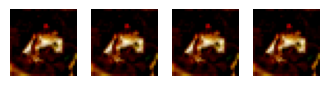

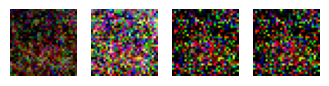

In [32]:
plt.figure(figsize=(STEPS, STEPS))
for i in range(STEPS):
    plt.subplot(STEPS, STEPS, i + 1)
    plt.imshow(np.clip(x_train[0], 0, 1))
    plt.axis('off')
plt.show()

reconstructed = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))

plt.figure(figsize=(STEPS, STEPS))
for i in range(STEPS):
    plt.subplot(STEPS, STEPS, i + 1)
    reconstructed += patches[i]
    plt.imshow(np.clip(reconstructed,0 ,1))
    plt.axis('off')
plt.show()
